# Stochastic gradient Langevin dynamics

In [1]:
import flax.linen as nn
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from jax.flatten_util import ravel_pytree
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import StandardScaler

from pbnn.mcmc.langevin import sgld
from pbnn.utils.plot import plot_on_axis

%load_ext watermark

### Generate data

In [2]:
def test_function(x):
    return np.sin(2.0 * x) + np.cos(x)


n = 100
noise_level = 0.1

np.random.seed(0)
X = 20 * np.random.rand(n, 1)
X_test = np.linspace(0, 20, 200)[:, None]

noise, noise_test = (
    np.random.randn(n, 1) * noise_level,
    np.random.randn(len(X_test), 1) * noise_level,
)

y = test_function(X) + noise
y_test = test_function(X_test) + noise_test

scaler = StandardScaler()
X_ = scaler.fit_transform(X)
X_test_ = scaler.transform(X_test)

X_, y = jnp.array(X_), jnp.array(y)
X_test_, y_test = jnp.array(X_test_), jnp.array(y_test)

### Define the network, loglikelihood and logprior 

In [3]:
# define loglikelihood et logprior
class MLP(nn.Module):
    """Simple MLP."""

    hidden_features: int
    out_features: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(
            features=self.hidden_features,
            kernel_init=nn.initializers.normal(),
            bias_init=nn.initializers.normal(),
        )(x)
        x = nn.tanh(x)
        x = nn.Dense(
            features=self.hidden_features,
            kernel_init=nn.initializers.normal(),
            bias_init=nn.initializers.normal(),
        )(x)
        x = nn.tanh(x)
        x = nn.Dense(
            features=self.out_features,
            kernel_init=nn.initializers.normal(),
            bias_init=nn.initializers.normal(),
        )(x)
        return x


network = MLP(hidden_features=50, out_features=1)


def loglikelihood_fn(parameters, data, sig_noise: float = noise_level):
    """Gaussian log-likelihood"""
    X, y = data
    return -jnp.sum(
        0.5 * (y - network.apply({"params": parameters}, X)) ** 2 / sig_noise**2
    )


def logprior_fn(parameters):
    """Compute the value of the log-prior density function."""
    flat_params, _ = ravel_pytree(parameters)
    return jnp.sum(stats.norm.logpdf(flat_params))

### Run the SGLD algorithm

In [4]:
# set some hyperparameters
step_size = 1e-5
num_iterations = 100_000
burnin = 80_000
batch_size = 32

# generate initial positions
rng_key = jr.PRNGKey(0)
keys = jr.split(rng_key)

init_positions = network.init(keys[0], X_)["params"]

# run SGLD
positions, ravel_fn, predict_fn = sgld(
    X=X_,
    y=y,
    loglikelihood_fn=loglikelihood_fn,
    logprior_fn=logprior_fn,
    init_positions=init_positions,
    batch_size=batch_size,
    step_size=step_size,
    num_iterations=num_iterations,
    rng_key=keys[1],
)

# remove burnin and thin manually
positions = jax.tree_util.tree_map(lambda xx: xx[burnin::100], positions)

# predict
f_predictions = predict_fn(network, positions, X_test_).squeeze()

# generate the noisy predictions
_, key = jr.split(keys[1])
y_predictions = f_predictions + noise_level * jr.normal(
    key, shape=(len(f_predictions), 1)
)

### Plot the prediction intervals

<Axes: title={'center': 'sgld'}, xlabel='$x$', ylabel='$y$'>

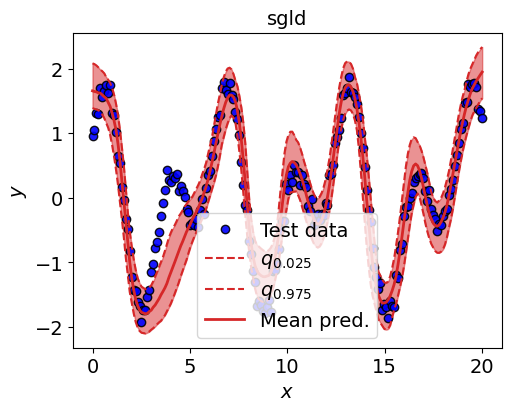

In [5]:
fig = plt.figure(constrained_layout=True, figsize=(5, 4))
gs = GridSpec(nrows=1, ncols=1, figure=fig)
alpha = 0.05

mean_prediction = jnp.median(y_predictions, axis=0)
qlow = jnp.quantile(y_predictions, 0.5 * alpha, axis=0)
qhigh = jnp.quantile(y_predictions, (1 - 0.5 * alpha), axis=0)

ax = fig.add_subplot(gs[0])
plot_on_axis(ax, X_test, y_test, mean_prediction, qlow, qhigh, title="sgld")

In [6]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Brian Staber'

Author: Brian Staber

Last updated: Sun Aug 31 2025

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

flax      : 0.10.4
matplotlib: 3.10.1
jax       : 0.5.3
sklearn   : 1.6.1
blackjax  : 1.2.5
pbnn      : 0.1.0
numpy     : 2.2.4

Watermark: 2.5.0

